<a href="https://colab.research.google.com/github/Dominique-Thorendal-Research/momentum_rotation/blob/main/momentum_rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Momentum ETF Rotation — Learn‑by‑Doing Notebook

This notebook teaches you how to build a **momentum ETF rotation** strategy using `yfinance` for data and `vectorbt` for backtesting.

**Idea:** Every month, pick the **top N** ETFs by past **X‑day** return and hold them equally until next rebalance.

You will learn:
- Data download & cleaning
- Feature engineering (rolling momentum)
- Building target weights for rotation
- Running a backtest with `vectorbt`
- Interpreting stats
- Doing a tiny parameter sweep
- A quick train/test split for sanity


In [ ]:
# If you haven't installed these yet, run this cell once.
# (In Anaconda/VSCode, using your working environment is fine.)
# You can comment out lines that you already have installed.
# Note: Restart kernel after install if imports fail.
!pip install yfinance vectorbt backtesting bt matplotlib pandas numpy

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

pd.options.display.width = 120
pd.options.display.max_columns = 20


## Configuration

In [ ]:
# Universe: broad, diversified ETFs added later "XLK", "XLF", "XLV", "LQD", "HYG"]
TICKERS = ["SPY", "QQQ", "IWM", "EFA", "TLT", "GLD", "XLK", "XLV"]
START = "2006-01-01"         # multiple regimes
INIT_CASH = 100_000
FEES = 0.0025                 # 10 bps per trade before:0.001
SLIPPAGE = 0.001            # 5 bps orig 0.0005

# Base strategy params (we'll sweep them later)
LOOKBACK_DAYS = 126           # ~3 months = 63
TOP_N = 3                    # hold top 2
REBAL_FREQ = "M"             # rebalance monthly


![image.png](attachment:image.png)

## 1) Download & inspect prices

In [ ]:
px = yf.download(TICKERS, start=START)["Close"].dropna(how="all")
px = px.loc[:, TICKERS].dropna()
px.tail(10)


/tmp/ipython-input-340276521.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(TICKERS, start=START)["Close"].dropna(how="all")
[*********************100%***********************]  8 of 8 completed


Ticker,SPY,QQQ,IWM,EFA,TLT,GLD,XLK,XLV
Date,,,,,,,,
2025-11-03,683.340027,632.080017,245.440002,94.529999,89.739998,368.779999,301.910004,144.449997
2025-11-04,675.239990,619.250000,241.199997,93.559998,89.940002,362.320007,293.940002,145.100006
2025-11-05,677.580017,623.280029,244.679993,94.160004,88.959999,366.510010,295.089996,145.660004
2025-11-06,670.309998,611.669983,240.350006,93.949997,89.760002,366.070007,289.160004,145.940002
2025-11-07,670.969971,609.739990,241.610001,94.300003,89.570000,368.309998,288.160004,146.139999
2025-11-10,681.440002,623.229980,244.029999,95.290001,89.550003,378.380005,295.529999,147.279999
2025-11-11,683.000000,621.570007,244.240005,95.989998,89.959999,379.869995,293.010010,150.679993
2025-11-12,683.380005,621.080017,243.639999,96.559998,90.120003,385.989990,293.920013,152.820007
2025-11-13,672.039978,608.400024,236.789993,95.529999,89.379997,382.869995,286.589996,152.740005


## 2) Choose rebalance dates

In [ ]:
# Use last trading day of each month
rebal_dates = px.resample(REBAL_FREQ).last().index
rebal_dates[:5], rebal_dates[-5:]


/tmp/ipython-input-2808268241.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = px.resample(REBAL_FREQ).last().index


(DatetimeIndex(['2006-01-31', '2006-02-28', '2006-03-31', '2006-04-30', '2006-05-31'], dtype='datetime64[ns]', name='Date', freq='ME'),
 DatetimeIndex(['2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30'], dtype='datetime64[ns]', name='Date', freq='ME'))

## 3) Momentum feature (rolling total return)

In [ ]:
# Rolling total return over LOOKBACK_DAYS
momentum = px.pct_change(LOOKBACK_DAYS)

# Align momentum to each rebal date (use last known value on that date)
mom_on_rebal = momentum.reindex(rebal_dates, method="ffill").dropna(how="all")
mom_on_rebal.tail()


Ticker,SPY,QQQ,IWM,EFA,TLT,GLD,XLK,XLV
Date,,,,,,,,
2025-07-31,0.056572,0.087664,-0.025371,0.125325,0.008981,0.191817,0.137644,-0.096803
2025-08-31,0.092099,0.125395,0.101092,0.140773,-0.042562,0.208151,0.167679,-0.069225
2025-09-30,0.197736,0.283249,0.219696,0.162205,0.003913,0.233671,0.369091,-0.037916
2025-10-31,0.210341,0.289828,0.235092,0.116451,0.048423,0.235385,0.392204,0.051046
2025-11-30,0.137302,0.170160,0.138013,0.110841,0.052823,0.277732,0.230357,0.151495


In [ ]:
#momentum.tail()
momentum.std()

,0
Ticker,
SPY,0.115780
QQQ,0.138424
IWM,0.153268
EFA,0.135866
TLT,0.102897
GLD,0.116180
XLK,0.137165
XLF,0.185874
XLV,0.092307


## 4) Build target weights from ranks

### Strategy 1: Orig momentum

In [ ]:
# Orig momentum strategy
def build_rotation_weights(momentum_subset: pd.DataFrame, top_n: int) -> pd.DataFrame:
    """Equal-weight the top_n tickers by momentum at each rebalance date."""
    ranks = momentum_subset.rank(axis=1, ascending=False, method="first")
    select = (ranks <= top_n).astype(float)
    w = select.div(select.sum(axis=1), axis=0).fillna(0.0)

    return w

w_rebal = build_rotation_weights(mom_on_rebal, TOP_N)
w_rebal.tail()




Ticker,SPY,QQQ,IWM,EFA,TLT,GLD,XLK,XLV
Date,,,,,,,,
2025-07-31,0.0,0.000000,0.0,0.333333,0.0,0.333333,0.333333,0.0
2025-08-31,0.0,0.000000,0.0,0.333333,0.0,0.333333,0.333333,0.0
2025-09-30,0.0,0.333333,0.0,0.000000,0.0,0.333333,0.333333,0.0
2025-10-31,0.0,0.333333,0.0,0.000000,0.0,0.333333,0.333333,0.0
2025-11-30,0.0,0.333333,0.0,0.000000,0.0,0.333333,0.333333,0.0


### Strategy 2: Risk Parity

In [ ]:
# Risk Parity
def build_rp_weights(momentum_subset: pd.DataFrame, prices: pd.DataFrame, top_n: int, vol_window: int = 20) -> pd.DataFrame:
    """Risk-parity weighting within top_n winners."""
    ranks = momentum_subset.rank(axis=1, ascending=False, method="first")
    select = (ranks <= top_n).astype(float)

    # Compute rolling vol (annualized optional)
    vol = prices.pct_change().rolling(vol_window).std()
    vol_r = vol.reindex(momentum_subset.index, method="ffill")

    # Inverse-vol weights among selected
    inv_vol = 1 / vol_r
    inv_vol = inv_vol * select  # zero out non-selected assets
    w = inv_vol.div(inv_vol.sum(axis=1), axis=0).fillna(0.0)
    return w

w_rebal = build_rp_weights(mom_on_rebal, px, TOP_N)


### Add Momentum > 0

In [ ]:
composite_mom = (mom_on_rebal * w_rebal).sum(axis=1)
composite_mom.tail()
risk_off = composite_mom < 0
risk_off.tail()
w_defensive = w_rebal.copy()

for date in w_defensive.index:
    if composite_mom.loc[date] < 0:
        # Set all risky weights to 0, invest fully in TLT
        w_defensive.loc[date] = 0
        w_defensive.loc[date, "TLT"] = 1.0
w_defensive


Ticker,SPY,QQQ,IWM,EFA,TLT,GLD,XLK,XLV
Date,,,,,,,,
2006-07-31,0.453300,0.000000,0.0,0.296679,0.000000,0.250021,0.000000,0.000000
2006-08-31,0.498195,0.000000,0.0,0.313977,0.000000,0.187827,0.000000,0.000000
2006-09-30,0.000000,0.000000,0.0,0.246859,0.400065,0.000000,0.000000,0.353076
2006-10-31,0.403551,0.000000,0.0,0.000000,0.288035,0.000000,0.000000,0.308414
2006-11-30,0.000000,0.266061,0.0,0.000000,0.457183,0.000000,0.276755,0.000000
...,...,...,...,...,...,...,...,...
2025-07-31,0.000000,0.000000,0.0,0.277095,0.000000,0.305618,0.417286,0.000000
2025-08-31,0.000000,0.000000,0.0,0.355626,0.000000,0.392519,0.251855,0.000000
2025-09-30,0.000000,0.447596,0.0,0.000000,0.000000,0.269958,0.282446,0.000000


## 5) Expand weights to all trading days

In [ ]:
# If using defensive (momentum <0 -> Treasury)
#w_rebal = w_defensive.copy()

# Forward-fill weights between rebalances
w_all = w_rebal.reindex(px.index).fillna(method="ffill").fillna(0.0)

# Safety re-normalization in case of any row sum drift
w_all = w_all.div(w_all.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
w_all.tail()


/tmp/ipython-input-1982027412.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  w_all = w_rebal.reindex(px.index).fillna(method="ffill").fillna(0.0)


Ticker,SPY,QQQ,IWM,EFA,TLT,GLD,XLK,XLV
Date,,,,,,,,
2025-11-10,0.0,0.413146,0.0,0.0,0.0,0.231409,0.355445,0.0
2025-11-11,0.0,0.413146,0.0,0.0,0.0,0.231409,0.355445,0.0
2025-11-12,0.0,0.413146,0.0,0.0,0.0,0.231409,0.355445,0.0
2025-11-13,0.0,0.413146,0.0,0.0,0.0,0.231409,0.355445,0.0
2025-11-14,0.0,0.413146,0.0,0.0,0.0,0.231409,0.355445,0.0


## 6) Backtest with `vectorbt`

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


,MomentumRotation
start,2006-01-02 00:00:00
end,2025-11-14 00:00:00
total_return,4.902071
cagr,0.093479
daily_sharpe,0.661497
max_drawdown,-0.293497


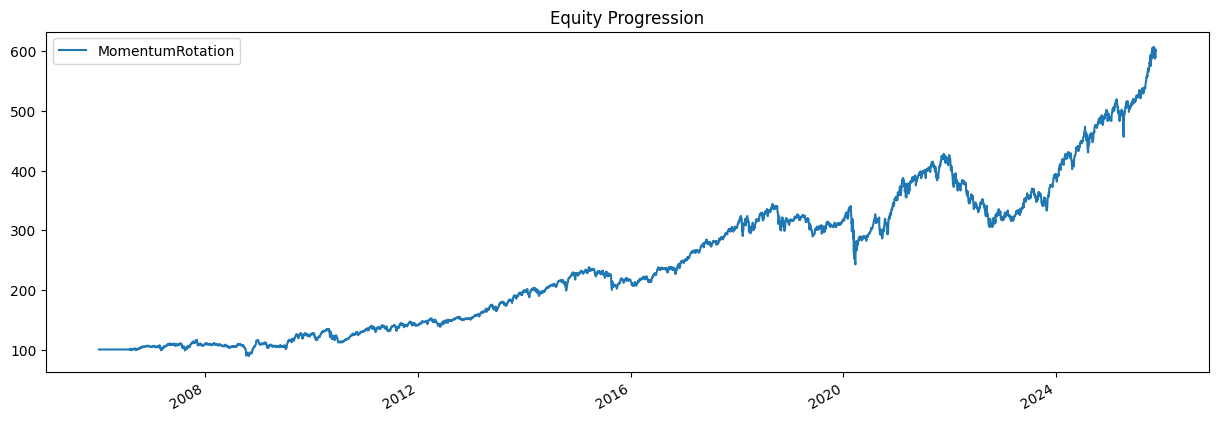

In [ ]:
import bt
import ffn

# --- helper: simple commission model (10 bps per notional trade) ---
def bps_commissions(qty, price):
    # qty is shares; notional = |qty| * price
    # 10 bps = 0.001; change to FEES if you want to reuse your variable
    return abs(qty) * price * FEES

# Strategy: every month apply target weights from w_all and rebalance
strat = bt.Strategy(
    'MomentumRotation',
    [
        bt.algos.RunMonthly(),                 # act on monthly schedule
        bt.algos.WeighTarget(w_all),           # use your target weight DF
        bt.algos.Rebalance()                   # trade to targets
    ]
)

bt_test = bt.Backtest(
    strat,
    px,                                       # price DataFrame
    initial_capital=INIT_CASH,
    commissions=bps_commissions,              # optional
    progress_bar=False
)

res = bt.run(bt_test)
res.plot()  # chart (optional)

stats = res.stats
stats.loc[['start', 'end', 'total_return', 'cagr', 'daily_sharpe', 'max_drawdown']]


## 7) Parameter sweep (robustness check)

🧭 7) Parameter Sweep – Finding Robust Strategy Settings

In this step, we test how sensitive our momentum rotation strategy is to different parameter choices:

Lookback period (lookback_days) → how far back we measure momentum (e.g., 2, 3, 4, 6 months).

Top N (top_n) → how many of the best-performing ETFs we hold each month.

For each combination, the code:

Builds momentum signals and target weights using make_rotation_weights().

Runs a full backtest using bt (without commissions for speed and stability).

Collects the daily Sharpe ratio as a performance score.

Stores results in a table (grid_df) that ranks parameter sets from best to worst.

This “parameter sweep” helps you identify which lookback window and number of assets are most robust — instead of overfitting to one arbitrary choice.
You’ll usually want to choose a region of stability (e.g., 63–84 days and Top 2 both work well), not just the single top Sharpe.

In [ ]:
import bt
import pandas as pd
import numpy as np

def make_rotation_weights(px_df: pd.DataFrame, lookback_days: int, top_n: int) -> pd.DataFrame:
    momentum = px_df.pct_change(lookback_days)
    rebal_dates = px_df.resample("M").last().index
    mom_r = momentum.reindex(rebal_dates, method="ffill").dropna(how="all")

    ranks = mom_r.rank(axis=1, ascending=False, method="first")
    select = (ranks <= top_n).astype(float)
    w_rebal = select.div(select.sum(axis=1), axis=0).fillna(0.0)

    # Expand to daily and normalize
    w_all = w_rebal.reindex(px_df.index).ffill().fillna(0.0)
    w_all = w_all.div(w_all.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
    return w_all

def run_rotation_bt(px_df, lookback_days, top_n):
    w = make_rotation_weights(px_df, lookback_days, top_n)
    strat = bt.Strategy(
        f"Rot_{lookback_days}_{top_n}",
        [bt.algos.RunMonthly(), bt.algos.WeighTarget(w), bt.algos.Rebalance()]
    )
    # ⚠️ commissions=None for stability/speed during sweep
    bt_test = bt.Backtest(strat, px_df, initial_capital=INIT_CASH, progress_bar=False)
    try:
        res = bt.run(bt_test)
        sharpe = float(res.stats.loc['daily_sharpe'])
    except Exception as e:
        # If anything blows up, return NaN so we can see it in the grid
        print(f"Param set failed (lb={lookback_days}, top_n={top_n}): {e}")
        sharpe = np.nan
    return sharpe

grid = []
for lb in [42, 63, 84, 126]:   # ~2m, 3m, 4m, 6m
    for tn in [1, 2, 3]:
        grid.append({"lookback": lb, "top_n": tn, "sharpe": run_rotation_bt(px, lb, tn)})

grid_df = pd.DataFrame(grid).sort_values("sharpe", ascending=False)
grid_df


/tmp/ipython-input-3893226704.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = px_df.resample("M").last().index
100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
/tmp/ipython-input-3893226704.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sharpe = float(res.stats.loc['daily_sharpe'])
/tmp/ipython-input-3893226704.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = px_df.resample("M").last().index
100%|██████████| 1/1 [00:00<00:00,  2.60it/s]
/tmp/ipython-input-3893226704.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sharpe = float(res.stats.loc['daily_sharpe'])
/tmp/ipython-input-3893226704.py:7: FutureWarning: 'M' is deprecated and will be rem

,lookback,top_n,sharpe
8,84,3,0.793923
5,63,3,0.737421
11,126,3,0.720819
2,42,3,0.692881
7,84,2,0.688934
1,42,2,0.675967
4,63,2,0.672779
10,126,2,0.611930
3,63,1,0.552754
9,126,1,0.467742


## 8) Train/Test split (out-of-sample)

🔍 8) Train/Test Split – Out-of-Sample Validation

Here, we check if the strategy generalizes by testing it on unseen data:

The price data is split at December 2016 into a training period and a testing (out-of-sample) period.

We build and backtest the same momentum strategy on each subset separately.

Key performance metrics are compared — Total Return, CAGR, Sharpe Ratio, Max Drawdown — for both periods.

If performance stays reasonably consistent between Train and Test, it suggests your strategy captures a real effect rather than noise or overfitting.

(You can toggle commissions on/off with use_commissions=True for realism once the runs are stable.)

In [ ]:
# Simple commission model (set to 0 for safety if needed)
def bps_commissions(qty, price, bps=10):
    return abs(qty) * price * (bps / 10_000)

def backtest_with_weights(px_df, lookback_days, top_n, use_commissions=True):
    w = make_rotation_weights(px_df, lookback_days, top_n)
    strat = bt.Strategy(
        "MomentumRotation",
        [bt.algos.RunMonthly(), bt.algos.WeighTarget(w), bt.algos.Rebalance()]
    )
    commissions_fn = (lambda q, p: bps_commissions(q, p, bps=10)) if use_commissions else None
    bt_test = bt.Backtest(
        strat, px_df, initial_capital=INIT_CASH,
        commissions=commissions_fn, progress_bar=False
    )
    res = bt.run(bt_test)
    view = res.stats.loc[['total_return', 'cagr', 'daily_sharpe', 'max_drawdown']]
    return res, view

split_date = "2016-12-31"
px_train = px.loc[:split_date]
px_test  = px.loc[split_date:]

# ✔️ Start with commissions off for stability; flip to True once it's working
res_train, train_stats = backtest_with_weights(px_train, LOOKBACK_DAYS, TOP_N, use_commissions=False)
res_test,  test_stats  = backtest_with_weights(px_test,  LOOKBACK_DAYS, TOP_N, use_commissions=False)

print("=== TRAIN ===")
display(train_stats)
print("=== TEST ===")
display(test_stats)

# Optional: turn commissions on and re-run just once for your chosen params
# res_train_c, train_stats_c = backtest_with_weights(px_train, LOOKBACK_DAYS, TOP_N, use_commissions=True)
# res_test_c,  test_stats_c  = backtest_with_weights(px_test,  LOOKBACK_DAYS, TOP_N, use_commissions=True)
# display(train_stats_c, test_stats_c)
# res_train.plot(title="Train Equity Curve")
# res_test.plot(title="Test Equity Curve")


/tmp/ipython-input-3893226704.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = px_df.resample("M").last().index
100%|██████████| 1/1 [00:00<00:00,  4.30it/s]
/tmp/ipython-input-3893226704.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = px_df.resample("M").last().index
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

=== TRAIN ===


,MomentumRotation
total_return,1.612887
cagr,0.091305
daily_sharpe,0.694043
max_drawdown,-0.270333


=== TEST ===


,MomentumRotation
total_return,1.513325
cagr,0.109554
daily_sharpe,0.67968
max_drawdown,-0.289804


/tmp/ipython-input-3893226704.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = px_df.resample("M").last().index
100%|██████████| 11/11 [00:02<00:00,  4.10it/s]


Stat                 MomentumRotation    BH_EQW      BH_60_40    BH_SPY      BH_QQQ      BH_IWM      BH_EFA      BH_TLT      BH_GLD      BH_XLK      BH_XLV
-------------------  ------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2006-01-02          2006-01-02  2006-01-02  2006-01-02  2006-01-02  2006-01-02  2006-01-02  2006-01-02  2006-01-02  2006-01-02  2006-01-02
End                  2025-11-14          2025-11-14  2025-11-14  2025-11-14  2025-11-14  2025-11-14  2025-11-14  2025-11-14  2025-11-14  2025-11-14  2025-11-14
Risk-free rate       0.00%               0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         647.98%             713.65%     394.37%     665.41%     1619.44%    354.09%     173.91%     80.87%      607.58%     1647.63%    563.35%
Daily Sharpe         0.72                0.78      

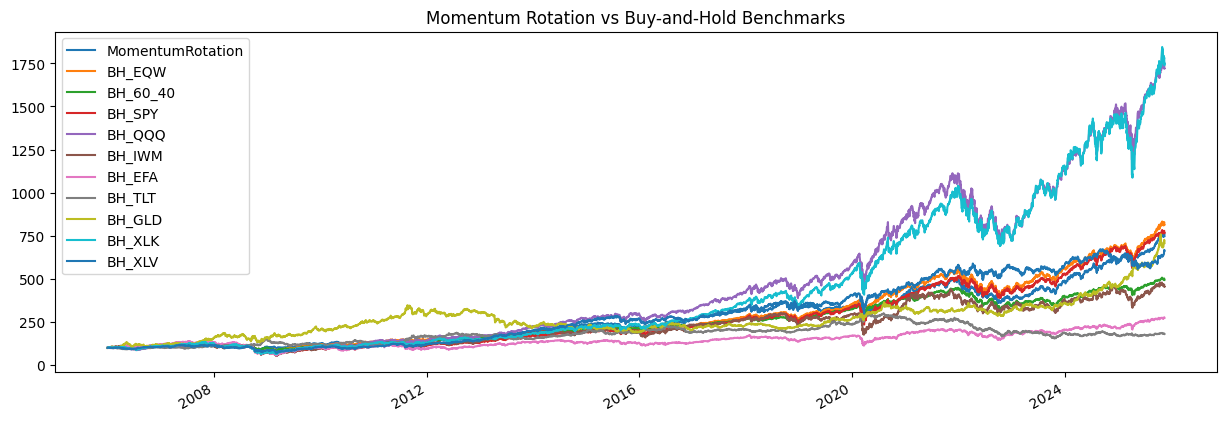

In [ ]:
import bt

# --- Optional: commissions toggle (set to None to keep it simple) ---
def bps_commissions(qty, price, bps=10):
    # One-time cost per trade; 10 bps = 0.001
    return abs(qty) * price * (bps / 10_000)

use_commissions = False
commissions_fn = (lambda q, p: bps_commissions(q, p, bps=10)) if use_commissions else None

# --- Helper to rebuild our rotation backtest with current params ---
def build_rotation_backtest(px_df, lookback_days, top_n, name="MomentumRotation", commissions_fn=None):
    w = make_rotation_weights(px_df, lookback_days, top_n)
    strat = bt.Strategy(
        name,
        [bt.algos.RunMonthly(), bt.algos.WeighTarget(w), bt.algos.Rebalance()]
    )
    return bt.Backtest(
        strat, px_df, initial_capital=INIT_CASH,
        commissions=commissions_fn, progress_bar=False
    )

# --- Buy & hold helpers ---
def buy_and_hold_backtest(px_df, ticker, commissions_fn=None):
    # Buy once at start, then sit tight
    strat = bt.Strategy(
        f"BH_{ticker}",
        [bt.algos.RunOnce(),
         bt.algos.SelectThese([ticker]),
         bt.algos.WeighEqually(),
         bt.algos.Rebalance()]
    )
    return bt.Backtest(
        strat, px_df, initial_capital=INIT_CASH,
        commissions=commissions_fn, progress_bar=False
    )

def buy_and_hold_equal_weight(px_df, commissions_fn=None):
    strat = bt.Strategy(
        "BH_EQW",
        [bt.algos.RunOnce(),
         bt.algos.SelectAll(),
         bt.algos.WeighEqually(),
         bt.algos.Rebalance()]
    )
    return bt.Backtest(
        strat, px_df, initial_capital=INIT_CASH,
        commissions=commissions_fn, progress_bar=False
    )

def sixty_forty_backtest(px_df, commissions_fn=None):
    # Monthly rebalanced 60% SPY / 40% TLT
    strat = bt.Strategy(
        "BH_60_40",
        [
            bt.algos.RunMonthly(),               # rebalance monthly
            bt.algos.SelectThese(["SPY", "TLT"]),
            bt.algos.WeighSpecified(SPY=0.6, TLT=0.4),
            bt.algos.Rebalance()
        ]
    )
    return bt.Backtest(
        strat, px_df, initial_capital=INIT_CASH,
        commissions=commissions_fn, progress_bar=False
    )

# --- Build backtests ---
bkt_rotation   = build_rotation_backtest(px, LOOKBACK_DAYS, TOP_N, commissions_fn=commissions_fn)
bkt_bh_eqw     = buy_and_hold_equal_weight(px, commissions_fn=commissions_fn)
bkt_benchmarks = [buy_and_hold_backtest(px, t, commissions_fn=commissions_fn) for t in TICKERS]
bkt_60_40 = sixty_forty_backtest(px, commissions_fn=commissions_fn)

# --- Run all together and plot ---
res_cmp = bt.run(bkt_rotation, bkt_bh_eqw, bkt_60_40, *bkt_benchmarks)

# Equity curves (normalized to initial capital). Interactive in VS Code/Jupyter.
res_cmp.plot(title="Momentum Rotation vs Buy-and-Hold Benchmarks")

# Compact stats view for each strategy
try:
    # Some bt versions support .display(); if not, fall back to stats table
    res_cmp.display()
except Exception:
    stats_tbl = res_cmp.stats  # one row per metric; columns per strategy
    display(stats_tbl.loc[['total_return', 'cagr', 'daily_sharpe', 'max_drawdown']])


Sharpe Ratio = E(return)/Volatility
SR = mu / sigma


## 9) Exercises (CFA L2 tie‑ins)

1. **Risk‑parity within winners:** Compute 20‑day volatility per ETF and weight winners ∝ 1/vol instead of equal weight.  
2. **Drawdown control:** If composite momentum (avg of winners’ momentum) < 0, rotate to `TLT` or cash.  
3. **Cost sensitivity:** Re-run with `FEES = 0.0025`, `SLIPPAGE = 0.001` and compare Sharpe.  
4. **Benchmark attribution:** Compare against a **60/40 (SPY/TLT)** benchmark: active return, active risk, information ratio.  
5. **Universe variants:** Add sector ETFs (XLK, XLF, XLV) or credit (LQD, HYG) and re‑test.


1. Org. top 3 3M lookback:
    - sharpe:
    - CAGR:

2. Risk parity top 3 3M Lookback:
3. Risk parity top 3 6M Lookback:
      cagr	0.119053
      daily_sharpe	0.900316
      max_drawdown	-0.262338
4. Risk parity top 3 6M Lookback w/ defense:
      total_return	9.02364
      cagr	0.12315
      daily_sharpe	0.906965
      max_drawdown	-0.354734









## Q3 Cost Sensitivity
*   4.
total_return	7.620296
cagr	0.114647
daily_sharpe	0.852019
max_drawdown	-0.361864




## Q4 benchmark attribution
total_return	3.921744
cagr	0.083611
daily_sharpe	0.78803
max_drawdown	-0.311242

In [ ]:
prices = res_cmp.prices        # DataFrame: columns = strategy names
rets = prices.pct_change().dropna()

port_name  = "MomentumRotation"   # or whatever you called it
bench_name = "BH_60_40"

port_rets  = rets[port_name]
bench_rets = rets[bench_name]
active_rets = port_rets - bench_rets
active_rets.tail(5)


,0
2025-11-10,0.010624
2025-11-11,-0.002447
2025-11-12,0.003401
2025-11-13,-0.005426
2025-11-14,-0.002729


In [ ]:
ANN = 252  # trading days

# Approximate annualized active return
active_return_ann = active_rets.mean() * ANN

# Annualized active risk (tracking error)
active_risk_ann = active_rets.std() * (ANN ** 0.5)
active_return_ann_exact = (1 + active_rets).prod() ** (ANN / len(active_rets)) - 1

info_ratio = active_return_ann / active_risk_ann

print("Active return (ann):", active_return_ann)
print("Active return exact (geometric) (ann):", active_return_ann_exact)
print("Active risk (ann):  ", active_risk_ann)
print("Information ratio:  ", info_ratio)

Active return (ann): 0.02674675491182499
Active return exact (geometric) (ann): 0.02254063605167267
Active risk (ann):   0.09434876431630812
Information ratio:   0.2834881315684792


- Active return: Return over the benchmark

- What is active risk: standard deviation on active return

- What is Information raio: =Active return/active risk
- -> its like Sharpe ratio, but instead of comparing to rfr, you compare to benchmark

<Figure size 1400x600 with 0 Axes>

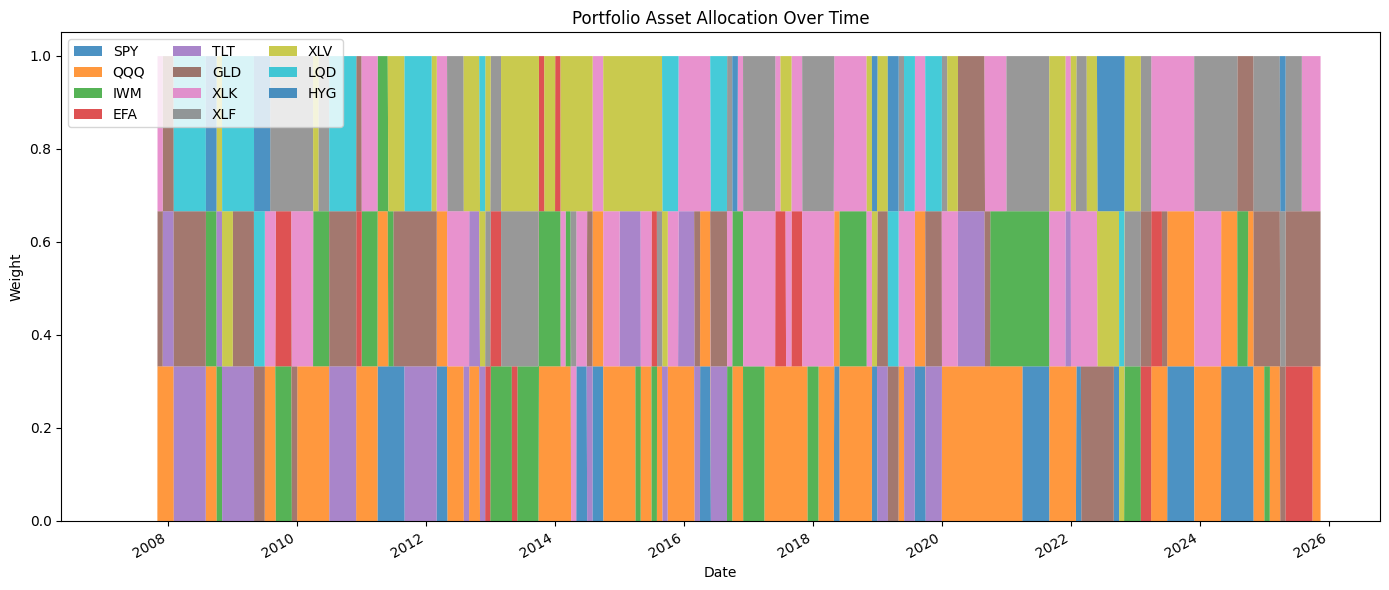

In [ ]:
# Plot asset selection
import matplotlib.pyplot as plt

# --- w_all is your daily weight DataFrame ---
# (forward-filled version of w_rebal used for backtesting)

# Make sure columns are in consistent order
w_all = w_all[TICKERS]

plt.figure(figsize=(14, 6))
w_all.plot.area(figsize=(14,6), linewidth=0, alpha=0.8)
plt.title("Portfolio Asset Allocation Over Time")
plt.ylabel("Weight")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=3)
plt.tight_layout()
plt.show()


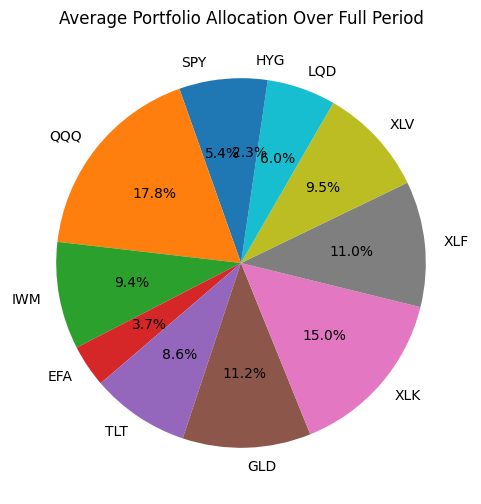

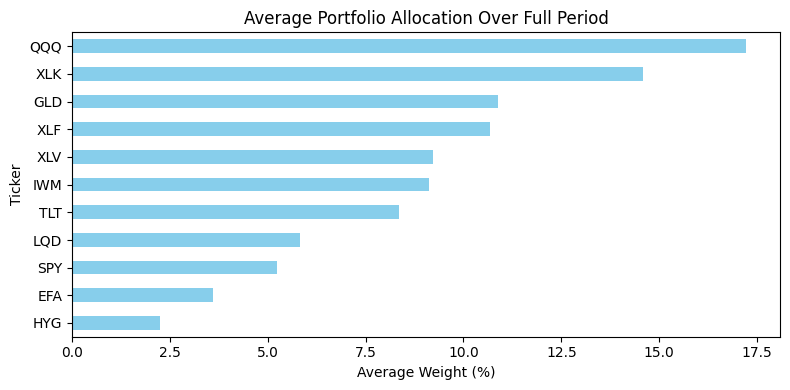

,0
Ticker,
SPY,5.247045
QQQ,17.221985
IWM,9.112915
EFA,3.595330
TLT,8.358251
GLD,10.878542
XLK,14.587783
XLF,10.664958
XLV,9.226826


In [ ]:
import matplotlib.pyplot as plt

# --- average weight per ETF across full backtest ---
avg_alloc = w_all.mean() * 100  # in %

# Option 1: Pie chart
plt.figure(figsize=(6, 6))
plt.pie(avg_alloc, labels=avg_alloc.index, autopct="%1.1f%%", startangle=90)
plt.title("Average Portfolio Allocation Over Full Period")
plt.show()

# Option 2: Bar chart (often clearer)
plt.figure(figsize=(8,4))
avg_alloc.sort_values().plot(kind="barh", color="skyblue")
plt.title("Average Portfolio Allocation Over Full Period")
plt.xlabel("Average Weight (%)")
plt.tight_layout()
plt.show()

avg_alloc



Composite momentum < 0 in 4.6% of months (10 out of 218 rebalancing periods).


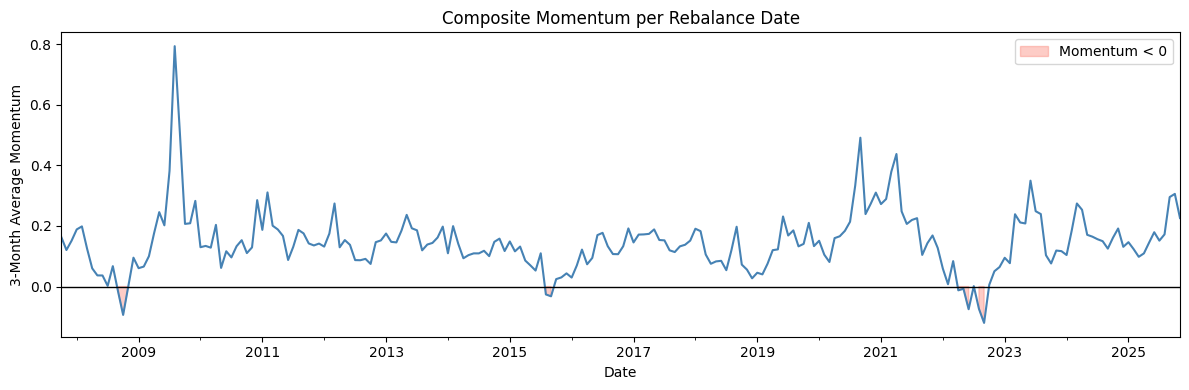

In [ ]:
import matplotlib.pyplot as plt

# --- Composite momentum per rebalance date ---
# (average of the momenta of all assets or just winners, depending on your model)
# If you already have mom_on_rebal and w_rebal:
composite_mom = (mom_on_rebal * w_rebal).sum(axis=1)

# Boolean: True when momentum < 0
risk_off = composite_mom < 0

# --- Summary statistics ---
risk_off_ratio = risk_off.mean() * 100
print(f"Composite momentum < 0 in {risk_off_ratio:.1f}% of months "
      f"({risk_off.sum()} out of {len(risk_off)} rebalancing periods).")

# --- Plot ---
fig, ax = plt.subplots(figsize=(12,4))
composite_mom.plot(ax=ax, color="steelblue", lw=1.5)
ax.axhline(0, color="black", lw=1)
ax.fill_between(
    composite_mom.index,
    0, composite_mom,
    where=(composite_mom < 0),
    color="salmon", alpha=0.4, label="Momentum < 0"
)
ax.set_title("Composite Momentum per Rebalance Date")
ax.set_ylabel("3-Month Average Momentum")
ax.legend()
plt.tight_layout()
plt.show()
